## **Description:Training data preparation flow**

*   Retreive the schema from adventureworks database in right order for all the tables
*   Retreive data from all base tables without header
*   create schema.json for every table based on retrieved schema
*   create the training dataset (processed: prompt,response) by using the schema.json and data files
*  Schuffle the training data to train the models

## Code Summary: Extract Data from PostgreSQL Database Tables

### Overview
This Python script connects to a PostgreSQL database named "adventureworks" and retrieves data from all base tables and schema. It is further used to create the training dataset in the format "prompt"/ "response" .

### Functionality
- PostgreSQL database connection using psycopg2.
- Query execution to fetch the list of base tables and table data.
- Iteration through each table and data extraction.
- CSV file creation and writing without headers using the csv module.
- Path manipulation and directory creation using os module.
- Further processing of datasets to generate training dataset.

### Dependencies
- psycopg2: For connecting to PostgreSQL database.
- csv: For CSV file operations.
- os: For path manipulation and directory creation.

### Usage
Ensure the PostgreSQL database is accessible and the necessary packages are installed. Then, run the script to extract data from all base tables and save it into CSV files.

In [1]:
!python --version

Python 3.10.12


In [ ]:
import os

# Define the root directory
root_dir = '/content/drive/MyDrive/etl-llm'
os.makedirs(root_dir, exist_ok=True)

# Define subdirectories
subdirs = [
    'data',
    'notebooks',
    'metrics',
    'scripts'
]

In [ ]:
pip install psycopg2

# **Extract Table Schema Information from adventureworks PostgreSQL Database in CSV format**
(*Will not execute from here due to issues with Postgres sql connection for google colab*)

In [ ]:
import psycopg2
import csv

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    dbname="adventureworks",
    user="postgres",
    password="*********",
    host="localhost",
    port="5432"
)

# Create a cursor object
cur = conn.cursor()

# Query to fetch table schema information with constraints
query = """
    SELECT
        col.table_schema,
        col.table_name,
        col.column_name,
        col.data_type,
        col.is_nullable,
        array_to_string(array_agg(DISTINCT tc.constraint_type), ', ') AS constraints,
        col.ordinal_position
    FROM
        information_schema.columns col
    LEFT JOIN
        information_schema.constraint_column_usage ccu
    ON
        col.table_schema = ccu.table_schema
        AND col.table_name = ccu.table_name
        AND col.column_name = ccu.column_name
    LEFT JOIN
        information_schema.table_constraints tc
    ON
        ccu.constraint_name = tc.constraint_name
        AND tc.table_schema = col.table_schema
        AND tc.table_name = col.table_name
    WHERE
        col.table_schema NOT IN ('information_schema', 'pg_catalog')
    GROUP BY
        col.table_schema,
        col.table_name,
        col.column_name,
        col.data_type,
        col.is_nullable,
        col.ordinal_position
    ORDER BY
        col.table_schema,
        col.table_name,
        col.ordinal_position;
"""

# Execute the query
cur.execute(query)

# Fetch all rows
rows = cur.fetchall()

# Close the cursor
cur.close()

# Close the connection
conn.close()

# Specify the file name for the CSV output
output_file = "adventureworks_tableschema_sequence.csv"

# Write table information to a CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['Table Schema', 'Table Name', 'Column Name', 'Data Type', 'Is Nullable', 'Constraint Type', 'Ordinal Position'])
    # Write rows
    for row in rows:
        writer.writerow(row)

print("Table schema information with constraints extracted and saved to:", output_file)


# **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Schema extract for all the base tables

In [ ]:
import pandas as pd
schema_df = pd.read_csv("/content/drive/MyDrive/etl-llm/schema/adventureworks_tableschema_sequence.csv")
schema_df.head(5)

,Table Schema,Table Name,Column Name,Data Type,Is Nullable,Constraint Type,Ordinal Position
0,hr,d,id,integer,YES,NaN,1
1,hr,d,departmentid,integer,YES,NaN,2
2,hr,d,name,character varying,YES,NaN,3
3,hr,d,groupname,character varying,YES,NaN,4
4,hr,d,modifieddate,timestamp without time zone,YES,NaN,5


## Code Summary: Extract Data from PostgreSQL Database Tables (without Headers)

### Overview
This Python script connects to a PostgreSQL database named "adventureworks" and retrieves data from all base tables. It then saves the data from each table into separate CSV files without headers, using the table name as the filename. If no base tables are found in the database, it prints a message indicating that.

In [ ]:
import psycopg2
import csv
import os

try:
    # Connect to your PostgreSQL database
    conn = psycopg2.connect(
        dbname="adventureworks",
        user="postgres",
        password="*********",
        host="localhost",
        port="5432"
    )

    # Create a cursor object
    cur = conn.cursor()

    # Execute a query to get the list of base tables
    cur.execute("""
        SELECT table_schema, table_name
      FROM information_schema.tables
      WHERE table_type = 'BASE TABLE';
    """)

    # Fetch all table names
    tables = cur.fetchall()

    if not tables:
        print("No base tables found in the database.")
    else:
        # Get the current working directory
        current_dir = os.getcwd()

        # Specify the directory where datasets are stored, one directory above in the folder named 'datasets'
        datasets_dir = os.path.abspath(os.path.join(current_dir, '..', 'datasets'))

        # Specify the subfolder for adventureworks
        adventureworks_dir = os.path.join(datasets_dir, 'adventureworks', 'data')

        # Ensure that the subfolder exists, create it if it doesn't
        if not os.path.exists(adventureworks_dir):
            os.makedirs(adventureworks_dir)

        # Iterate through each table
        # Loop through the tables and query each one
        for table in tables:
            schema_name, table_name = table
        # Execute a query to fetch data from the current table
            cur.execute(f"SELECT * FROM {schema_name}.{table_name}")
        # Fetch all rows from the result set
            rows = cur.fetchall()
        # Process the rows as needed


            # Specify the file path for the CSV output
            output_file = os.path.join(adventureworks_dir, f"{table_name}.csv")

            # Write data to a CSV file without headers
            with open(output_file, mode='w', newline='') as file:
                writer = csv.writer(file)
                # Write rows
                for row in rows:
                    writer.writerow(row)

            print(f"Data extracted from table '{table_name}' and saved to '{output_file}'")

except psycopg2.Error as e:
    print("Error:", e)

finally:
    # Close cursor and connection
    cur.close()
    conn.close()

# **Generate schema.json for the table schema**

Usage: Generate schema.json for all the base tables using schema defination from adventureworks database

In [ ]:
import pandas as pd
import json
import os

# File paths
csv_file_path = "/content/drive/MyDrive/etl-llm/schema/adventureworks_tableschema_sequence.csv"  # Update this path to your CSV file location
output_dir = "/content/drive/MyDrive/etl-llm/schema/schema_adventureadw"  # Update this path to your desired output directory

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Group the dataframe by table
grouped = df.groupby(['Table Schema', 'Table Name'])

# Iterate over each group (i.e., each table) and create a JSON schema file for each
for (schema_name, table_name), group in grouped:
    schema = {}
    for _, row in group.iterrows():
        column_name = row['Column Name']
        column_type = row['Data Type']
        constraints = row['Constraint Type'] if not pd.isna(row['Constraint Type']) else None
        is_nullable = row['Is Nullable']

        # Initialize the schema for the column if it does not exist
        schema[column_name] = {
            "type": column_type,
            "constraints": []
        }

        # Add constraints if they exist and are not already in the list
        if constraints and constraints not in schema[column_name]['constraints']:
            schema[column_name]['constraints'].append(constraints)

    # Write the schema to a JSON file
    json_file_path = os.path.join(output_dir, f'{table_name}_schema.json')
    with open(json_file_path, 'w') as jsonfile:
        json.dump(schema, jsonfile, indent=4)

print(f'Schema files have been created in {output_dir}')


Schema files have been created in /content/drive/MyDrive/etl-llm/schema/schema_adventureadw


# **Training data (Proccessed_data.csv) created for some base tables.**

Usage: Picking first 200 records from all base tables

In [ ]:
import os
import json

data_path = "/content/drive/MyDrive/etl-llm/schema/Adventuredataset_WH"
schema_path = "/content/drive/MyDrive/etl-llm/schema/schema_adventureadw"

data = "prompt,response\n"

# Iterate through each data file
for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        schema_filename = filename.replace('.csv', '_schema.json')  # Replace .csv with _schema.json

        # Check if schema file exists for the data file
        if schema_filename not in os.listdir(schema_path):
            print(f"Schema file {schema_filename} not found for {filename}")
            continue

        # Load schema file
        with open(os.path.join(schema_path, schema_filename), 'r') as f:
            df_schema = json.load(f)

        # Read data file
        with open(os.path.join(data_path, filename), 'r') as file:
            header_flag = True
            count = 0
            for line in file:
                if header_flag:
                    header_flag = False
                    continue

                # Preprocessing each line
                line = line.strip()  # Remove leading/trailing whitespace and newline characters
                line_replacement = line.replace('"', "'")  # Replace double quotes with single quotes

                # Constructing the response using JSON string of the schema
                schema_replacement = json.dumps(df_schema).replace('"', "'")

                # Constructing the prompt,response pair
                data += f'"{line_replacement}","{schema_replacement}"\n'

                count += 1
                if count >= 160:
                    break  # Stop reading the file after 200 records

# Writing the processed data to a file
output_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full.csv"
with open(output_file, 'w') as f:
    f.write(data)

print("Processing complete.")


Schema file pg_amop_schema.json not found for pg_amop.csv
Schema file pg_attrdef_schema.json not found for pg_attrdef.csv
Schema file transactionhistory_schema.json not found for transactionhistory.csv
Schema file pg_largeobject_metadata_schema.json not found for pg_largeobject_metadata.csv
Schema file pg_subscription_schema.json not found for pg_subscription.csv
Schema file pg_auth_members_schema.json not found for pg_auth_members.csv
Schema file pg_foreign_server_schema.json not found for pg_foreign_server.csv
Schema file pg_transform_schema.json not found for pg_transform.csv
Schema file pg_rewrite_schema.json not found for pg_rewrite.csv
Schema file pg_ts_config_map_schema.json not found for pg_ts_config_map.csv
Schema file pg_event_trigger_schema.json not found for pg_event_trigger.csv
Schema file scrapreason_schema.json not found for scrapreason.csv
Schema file pg_user_mapping_schema.json not found for pg_user_mapping.csv
Schema file pg_range_schema.json not found for pg_range.cs

#** Shuffle Training data**

In [ ]:
import pandas as pd

# Step 1: Read the CSV file into a DataFrame
input_csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full.csv"  # Replace with your CSV file path
df = pd.read_csv(input_csv_file)

# Step 2: Filter rows based on the values in the second column
# Assuming the second column is named 'Column2', replace with the actual column name or index
filtered_df = df[df.iloc[:, 1] != "{'productreviewid': {'type': 'integer', 'constraints': ['PRIMARY KEY']}, 'productid': {'type': 'integer', 'constraints': []}, 'reviewername': {'type': 'character varying', 'constraints': []}, 'reviewdate': {'type': 'timestamp without time zone', 'constraints': []}, 'emailaddress': {'type': 'character varying', 'constraints': []}, 'rating': {'type': 'integer', 'constraints': ['CHECK']}, 'comments': {'type': 'character varying', 'constraints': []}, 'modifieddate': {'type': 'timestamp without time zone', 'constraints': []}}"]  # Replace 'value_to_filter' with the value you want to filter out

# Step 3: Shuffle the DataFrame rows
df_shuffled = filtered_df.sample(frac=1).reset_index(drop=True)

# Step 4: Save the shuffled DataFrame back to a CSV file
output_csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv"  # Replace with your output CSV file path
df_shuffled.to_csv(output_csv_file, index=False)

print(f"Filtered and shuffled CSV saved to {output_csv_file}")


Filtered and shuffled CSV saved to /content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv


In [ ]:
import pandas as pd
import re

# Read the training dataset
df = pd.read_csv("/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv")

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract relevant information from the row
    prompt = row["prompt"]
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Add each field's type and constraints to the data list
    for field, type_, constraint in fields:
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt, field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Save the new DataFrame to a CSV file
new_df.to_csv("/content/drive/MyDrive/etl-llm/TrainingData/extracted_data.csv", index=False)

print("New CSV created successfully!")


New CSV created successfully!


In [ ]:
import pandas as pd
import re

# Read the training dataset
df = pd.read_csv("/content/drive/MyDrive/etl-llm/TrainingData/processed_data_adw_full_shuffledrows.csv")

# Initialize lists to store the extracted information
data = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract relevant information from the row
    prompt_values = row["prompt"].split(',')  # Assuming prompt values are separated by ','
    response = row["response"]

    # Extract field names, types, and constraints using regular expressions
    fields = re.findall(r"'(\w+)': {'type': '([^']*)', 'constraints': \[([^\]]*)\]", response)

    # Ensure prompt_values and fields have the same length
    if len(prompt_values) != len(fields):
        print(f"Skipping row {index}: Number of prompt values does not match number of fields")
        continue

    # Add each field's type and constraints to the data list
    for i, (field, type_, constraint) in enumerate(fields):
        # Clean up the constraint string
        constraint_cleaned = constraint.replace("'", "").strip()
        if not constraint_cleaned:
            constraint_cleaned = "None"

        # Append the extracted information to the data list
        data.append([prompt_values[i], field, type_, constraint_cleaned])

# Create a new DataFrame with the extracted information
new_df = pd.DataFrame(data, columns=['Prompt', 'Field', 'Type', 'Constraint'])

# Save the new DataFrame to a CSV file
new_df.to_csv("/content/drive/MyDrive/etl-llm/TrainingData/extracted_data.csv", index=False)

print("New CSV created successfully!")


Skipping row 142: Number of prompt values does not match number of fields
Skipping row 275: Number of prompt values does not match number of fields
Skipping row 414: Number of prompt values does not match number of fields
Skipping row 523: Number of prompt values does not match number of fields
Skipping row 559: Number of prompt values does not match number of fields
Skipping row 642: Number of prompt values does not match number of fields
Skipping row 822: Number of prompt values does not match number of fields
Skipping row 1042: Number of prompt values does not match number of fields
Skipping row 1120: Number of prompt values does not match number of fields
Skipping row 1869: Number of prompt values does not match number of fields
Skipping row 1923: Number of prompt values does not match number of fields
Skipping row 1964: Number of prompt values does not match number of fields
Skipping row 2034: Number of prompt values does not match number of fields
Skipping row 2158: Number of pro

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total rows in input CSV File:  6011
Total Sampled Data:  6011
Unique values in the 'Datatype' column:
['char' 'varchar' 'timestamp' 'int' 'null' 'uuid' 'smallint' 'numeric'
 'date' 'bool' 'bytea']

Unique values in the 'Constraints' column:
['PRIMARY KEY' 'null' 'FOREIGN KEY']
Number of occurrences of each datatype:
Datatype
int          13685
timestamp     9437
varchar       6463
numeric       4329
smallint      3531
uuid          3035
char          1592
bool          1186
date           800
null           616
bytea          200
Name: count, dtype: int64

Number of occurrences of each constraint:
Constraints
null           35463
FOREIGN KEY     5427
PRIMARY KEY     3984
Name: count, dtype: int64


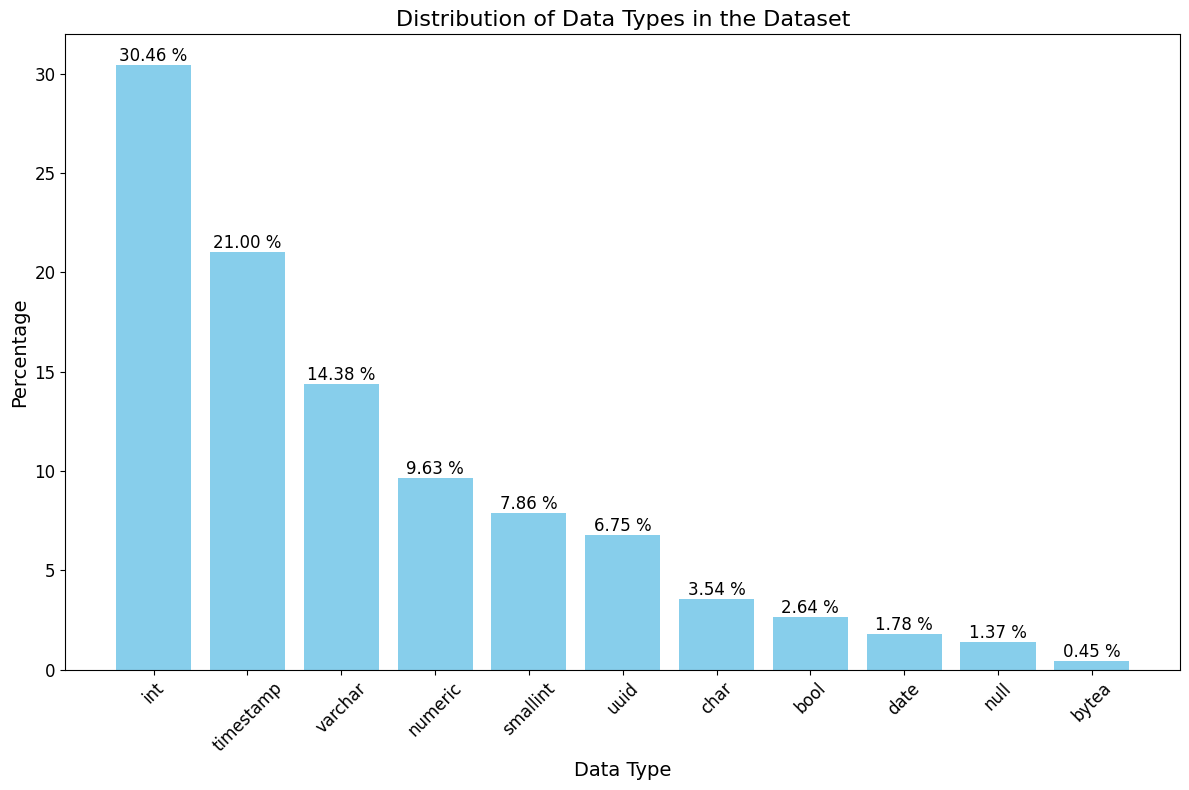

<Figure size 1400x1000 with 0 Axes>

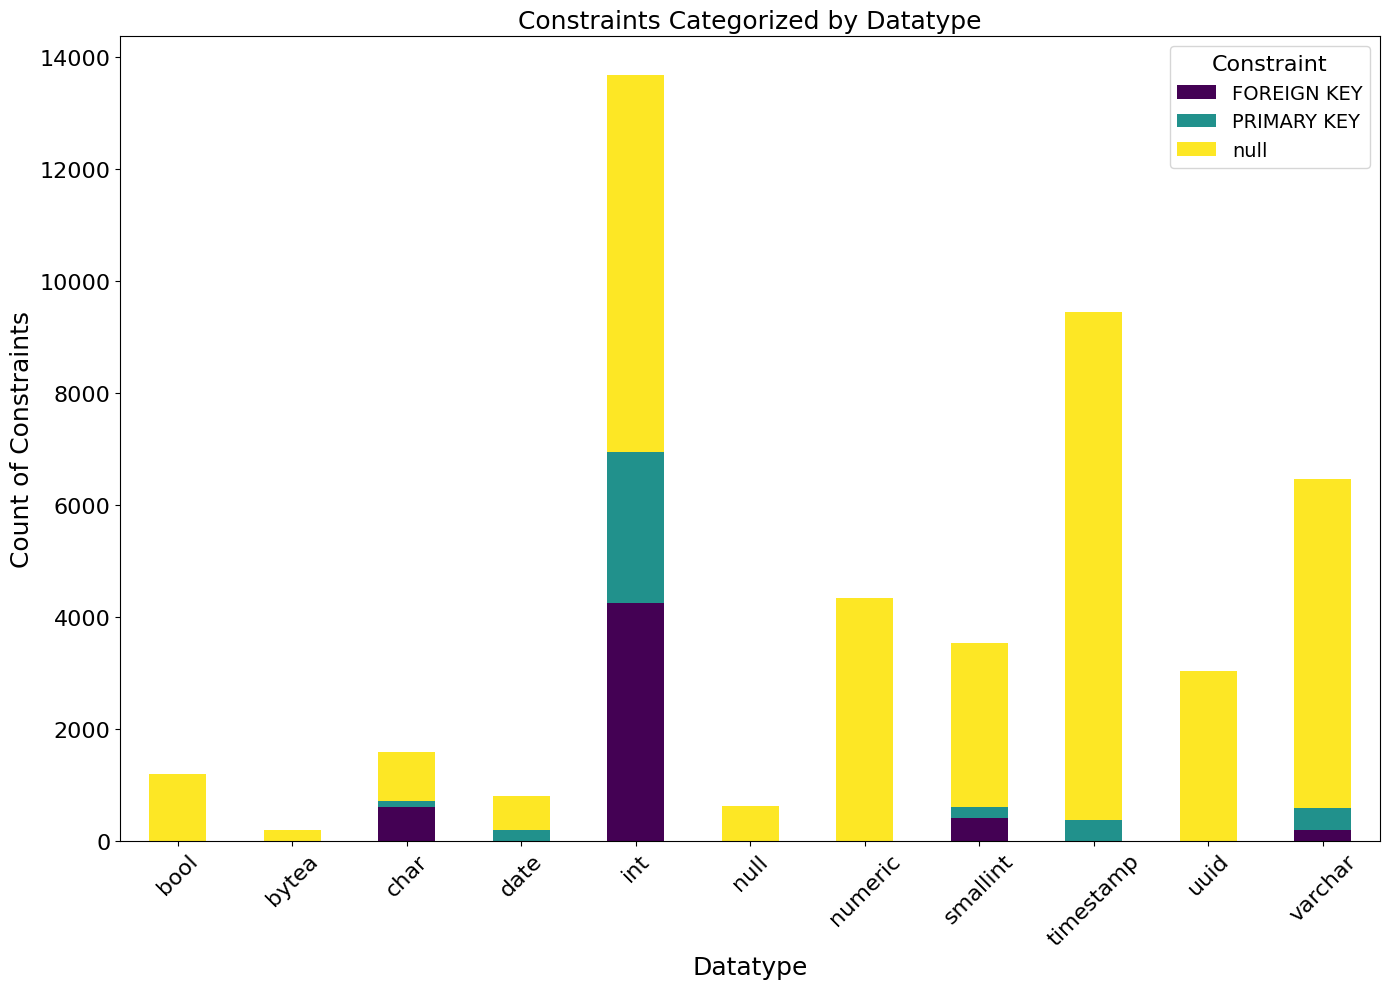

In [ ]:
# Import necessary libraries
import pandas as pd
import csv
import json
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Read the CSV file
csv_file = "/content/drive/MyDrive/etl-llm/TrainingData/processed_data_training_shuffledrows.csv"

# Check if the file exists
if not os.path.exists(csv_file):
    raise FileNotFoundError(f"The file {csv_file} does not exist. Please check the file path.")

# Initialize lists to store prompts and responses
prompts = []
responses = []

# Define the desired range (e.g., rows 10 to 30)
start_row = 0
end_row = 100000

try:
    with open(csv_file, newline='', encoding='utf-8') as csvfile:
        # Create a CSV reader
        reader = csv.reader(csvfile)

        # Skip the header
        header = next(reader)

        # Initialize a counter for total rows
        total_rows = 0

        # First, count the total number of rows
        for _ in reader:
            total_rows += 1
except OSError as e:
    print(f"Error reading the CSV file: {e}")
    raise

# Step 2: Open the CSV file
try:
    with open(csv_file, newline='', encoding='utf-8') as csvfile:
        # Create a CSV reader
        reader = csv.reader(csvfile)

        print("Total rows in input CSV File: ", total_rows)
        # Skip the header
        next(reader)
        # Iterate over each row in the CSV file
        for i, row in enumerate(reader):
            if i >= end_row:
                break
            if i >= start_row:
                # Append the prompt (first column) to the prompts list
                prompts.append(row[0])
                # Append the response (second column) to the responses list
                responses.append(row[1])
except OSError as e:
    print(f"Error reading the CSV file: {e}")
    raise

# Combine prompts and responses into a single list for easier sampling
combined_data = list(zip(prompts, responses))

# Sample 100% of the data
sampled_data = random.sample(combined_data, int(len(combined_data) * 1))

# Split the sampled data back into prompts and responses
sampled_prompts, sampled_responses = zip(*sampled_data)

# Convert sampled prompts and responses back to lists
sampled_prompts = list(sampled_prompts)
sampled_responses = list(sampled_responses)

# Use the sampled data for further processing
prompts = sampled_prompts
responses = sampled_responses
print("Total Sampled Data: ", len(prompts))

# Step 3: HANDLE PROMPT ###
flattened_prompts = [item for sublist in prompts for item in sublist.split(',')]

# Create a dataframe from the PROMPT list
PROMPT_DF = pd.DataFrame(flattened_prompts, columns=['Prompt_Element'])
PROMPT_DF['Prompt_Element'].replace('', 'No_Data', inplace=True)

# Step 4: HANDLE RESPONSE ###
# Initialize lists to store keys, datatypes, and constraints
keys = []
datatypes = []
constraints = []

# Data type mapping
data_type_mapping = {
    'integer': 'int',
    'uuid': 'uuid',
    'timestamp without time zone': 'timestamp',
    'numeric': 'numeric',
    'smallint': 'smallint',
    'character varying': 'varchar',
    'boolean': 'bool',
    'character': 'char',
    'text': 'text',
    'bytea': 'bytea',
    'date': 'date'
}

# Constraint mapping
constraint_mapping = {
    'PRIMARY KEY': 'PRIMARY KEY',
    'null': 'null',
    'CHECK': 'CHECK',
    'UNIQUE': 'UNIQUE',
    'CHECK, PRIMARY KEY': 'CHECK, PRIMARY KEY',
    'FOREIGN KEY':'FOREIGN KEY'
}

# Iterate over each response
for response in responses:
    # Replace single quotes with double quotes
    response_replaced = response.replace("'", '"')
    # Convert the JSON string to a Python dictionary
    response_dict = json.loads(response_replaced)
    # Extract keys, datatypes, and constraints
    for key, value in response_dict.items():
        keys.append(key)
        datatypes.append(value.get('type', 'null'))
        constraints.append(", ".join(value.get('constraints', ['null'])))

# Create a DataFrame from the lists
RESPONSE_DF = pd.DataFrame({
    'Key': keys,
    'Datatype': datatypes,
    'Constraints': constraints
})

# Ensure that 'null' is placed correctly where there are missing values
RESPONSE_DF['Datatype'].replace('', 'null', inplace=True)
RESPONSE_DF['Constraints'].replace('', 'null', inplace=True)

# Apply the mappings to the RESPONSE_DF DataFrame
RESPONSE_DF['Datatype'] = RESPONSE_DF['Datatype'].map(data_type_mapping).fillna('null')
RESPONSE_DF['Constraints'] = RESPONSE_DF['Constraints'].map(constraint_mapping).fillna('null')

# Step 5: MERGE PROMPT_DF AND RESPONSE_DF to make a MASTER DF ###
# Concatenate PROMPT_DF and RESPONSE_DF along columns
MASTER_DF_50 = pd.concat([PROMPT_DF, RESPONSE_DF], axis=1)

# Print unique values in the 'Datatype' column
unique_datatypes = RESPONSE_DF['Datatype'].unique()
print("Unique values in the 'Datatype' column:")
print(unique_datatypes)

# Print unique values in the 'Constraints' column
unique_constraints = RESPONSE_DF['Constraints'].unique()
print("\nUnique values in the 'Constraints' column:")
print(unique_constraints)

# Get the number of occurrences of each unique value in the 'Datatype' column
datatype_counts = MASTER_DF_50['Datatype'].value_counts()

# Get the number of occurrences of each unique value in the 'Constraints' column
constraint_counts = MASTER_DF_50['Constraints'].value_counts()

print("Number of occurrences of each datatype:")
print(datatype_counts)

print("\nNumber of occurrences of each constraint:")
print(constraint_counts)

# Get the data types of each column
#data_types = data.dtypes

# Classify columns by data type
#data_type_counts = data_types.value_counts()

# Convert the counts to a DataFrame for easier manipulation
data_type_counts_df50 = pd.DataFrame(datatype_counts, columns=['count'])

# Calculate the percentage distribution
data_type_counts_df50['percentage'] = (data_type_counts_df50['count'] / len(MASTER_DF_50)) * 100

# Plot the distribution of data types
plt.figure(figsize=(12, 8))
bars = plt.bar(data_type_counts_df50.index.astype(str), data_type_counts_df50['percentage'], color='skyblue')

# Add title and labels with improved font sizes
plt.title('Distribution of Data Types in the Dataset', fontsize=16)
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Step 6: Additional Plot for Constraints Categorized by Datatype ###
# Create a contingency table for constraints by datatype
constraint_by_datatype = pd.crosstab(MASTER_DF_50['Datatype'], MASTER_DF_50['Constraints'])

# Plot the constraints categorized by datatype
plt.figure(figsize=(14, 10))
constraint_by_datatype.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 10))

# Add title and labels with improved font sizes
plt.title('Constraints Categorized by Datatype', fontsize=18)
plt.xlabel('Datatype', fontsize=18)
plt.ylabel('Count of Constraints', fontsize=18)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add legend with improved font size
plt.legend(title='Constraint', fontsize=14, title_fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


# Modified script will continue processing records until it reaches the desired limit (400 records) for each of the specified data types (boolean, character varying, and character).

In [ ]:
import os
import json

data_path = "/content/drive/MyDrive/Colab Notebooks/Adventuredataset_WH"
schema_path = "/content/drive/MyDrive/Colab Notebooks/schemas_new"

data = "prompt,response\n"

# Define a dictionary to keep track of the number of records processed for each data type
processed_counts = {'boolean': 0, 'character varying': 0, 'character': 0}

total_records = 0  # Track the total number of records processed

# Iterate through each data file
for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        schema_filename = filename.replace('.csv', '_schema.json')  # Replace .csv with _schema.json

        # Check if schema file exists for the data file
        if schema_filename not in os.listdir(schema_path):
            print(f"Schema file {schema_filename} not found for {filename}")
            continue

        # Load schema file
        with open(os.path.join(schema_path, schema_filename), 'r') as f:
            df_schema = json.load(f)

        # Read data file
        with open(os.path.join(data_path, filename), 'r') as file:
            header_flag = True
            for line in file:
                if header_flag:
                    header_flag = False
                    continue

                # Preprocessing each line
                line = line.strip()  # Remove leading/trailing whitespace and newline characters
                line_replacement = line.replace('"', "'")  # Replace double quotes with single quotes

                # Constructing the response using JSON string of the schema
                schema_replacement = json.dumps(df_schema).replace('"', "'")

                # Constructing the prompt,response pair
                data += f'"{line_replacement}","{schema_replacement}"\n'

                # Update processed counts for relevant data types
                for data_type in processed_counts.keys():
                    if data_type in df_schema.values():
                        processed_counts[data_type] += 1

                total_records += 1

                # Check if the desired number of records is reached for each data type
                if all(count >= 300 for count in processed_counts.values()):
                    break  # Stop reading the file if the desired number of records is reached for all data types

                # Check if the total number of records reaches 5000
                if total_records >= 5000:
                    break  # Stop processing records if the total reaches 5000

            # Check if the total number of records reaches 5000 after processing each file
            if total_records >= 5000:
                break

# Writing the processed data to a file
output_file = "/content/drive/MyDrive/Colab Notebooks/TrainingData/processed_data_training_300.csv"
with open(output_file, 'w') as f:
    f.write(data)

print("Processing complete.")